## Imports

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchinfo import summary
import numpy as np
from collections import Counter
import os

## Set Device

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Get & Ready Dataset

In [22]:
def get_balanced_data(dataset, train_size=0.8):
    if isinstance(dataset.targets, torch.Tensor):
        targets = dataset.targets.numpy()
    else:
        targets = np.array(dataset.targets)

    class_counts = Counter(targets)
    min_class_count = min(class_counts.values())
    indices_per_class = {i: [] for i in range(10)}

    for idx, target in enumerate(targets):
        if len(indices_per_class[target]) < min_class_count:
            indices_per_class[target].append(idx)

    all_indices = []
    for cls in indices_per_class:
        all_indices.extend(indices_per_class[cls])

    np.random.shuffle(all_indices)
    train_count = int(len(all_indices) * train_size)
    train_indices = all_indices[:train_count]
    test_indices = all_indices[train_count:]

    return Subset(dataset, train_indices), Subset(dataset, test_indices)

## Plot Function

In [23]:
def plot_loss(losses, dataset_type):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.title(f'Training Loss Curve - {dataset_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'loss_curve_{dataset_type}.png')
    plt.show()
    plt.close()

## CNN Model

In [24]:
class ConvNet(nn.Module):
    def __init__(self, dataset_type='MNIST'):
        super(ConvNet, self).__init__()
        self.dataset_type = dataset_type
        # لایه‌های پیچشی
        if dataset_type == 'MNIST':
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.relu2 = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.dropout1 = nn.Dropout(0.25)
            self.fc1 = nn.Linear(64 * 7 * 7, 128)
        else:  # CIFAR-10
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.relu2 = nn.ReLU()
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.relu3 = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.dropout1 = nn.Dropout(0.25)
            self.fc1 = nn.Linear(128 * 4 * 4, 128)

        self.relu_fc = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool(self.relu2(self.bn2(self.conv2(x))))
        if self.dataset_type != 'MNIST':
            x = self.pool(self.relu3(self.bn3(self.conv3(x))))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


## Traning Function

In [25]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return losses


## Evaluate Function

In [26]:
def evaluate_model(model, loader, dataset_type):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    # رسم ماتریس Confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_type}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{dataset_type}.png')
    plt.show()
    plt.close()

    return acc, f1, cm


## Main Function

In [27]:
def main(dataset_type='CIFAR-10'):
    # تعریف تبدیل‌ها
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    input_shape = (3, 32, 32)

    # تقسیم داده‌ها
    train_subset, val_subset = get_balanced_data(dataset)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    # تعریف مدل
    model = ConvNet(dataset_type=dataset_type).to(device)

    # نمایش خلاصه مدل
    print(f"\nModel Summary for {dataset_type}:")
    summary(model, input_size=(1, *input_shape), device=str(device))

    # معیار و بهینه‌ساز
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # رسم گرافیک شبکه
    sample_input = torch.randn(1, *input_shape).to(device)
    out = model(sample_input)
    graph = make_dot(out, params=dict(model.named_parameters()))
    graph.render(f'network_graph_{dataset_type}', format='png', cleanup=True)

    # آموزش مدل
    losses = train_model(model, train_loader, criterion, optimizer)

    # رسم منحنی Loss
    plot_loss(losses, dataset_type)

    # ارزیابی مدل
    train_acc, train_f1, train_cm = evaluate_model(model, train_loader, f'{dataset_type}_Train')
    test_acc, test_f1, test_cm = evaluate_model(model, test_loader, f'{dataset_type}_Test')

    print(f'\n{dataset_type} Results:')
    print(f'Training Accuracy: {train_acc:.4f}, F1-Score: {train_f1:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}, F1-Score: {test_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Test Confusion Matrix:\n{test_cm}')


## Run ALL

Training on CIFAR-10 dataset...

Model Summary for CIFAR-10:
Epoch [1/25], Loss: 1.5589
Epoch [2/25], Loss: 1.2494
Epoch [3/25], Loss: 1.1300
Epoch [4/25], Loss: 1.0534
Epoch [5/25], Loss: 0.9953
Epoch [6/25], Loss: 0.9455
Epoch [7/25], Loss: 0.9066
Epoch [8/25], Loss: 0.8695
Epoch [9/25], Loss: 0.8333
Epoch [10/25], Loss: 0.7969
Epoch [11/25], Loss: 0.7725
Epoch [12/25], Loss: 0.7488
Epoch [13/25], Loss: 0.7163
Epoch [14/25], Loss: 0.6961
Epoch [15/25], Loss: 0.6669
Epoch [16/25], Loss: 0.6407
Epoch [17/25], Loss: 0.6250
Epoch [18/25], Loss: 0.6063
Epoch [19/25], Loss: 0.5902
Epoch [20/25], Loss: 0.5717
Epoch [21/25], Loss: 0.5524
Epoch [22/25], Loss: 0.5380
Epoch [23/25], Loss: 0.5196
Epoch [24/25], Loss: 0.5104
Epoch [25/25], Loss: 0.4944


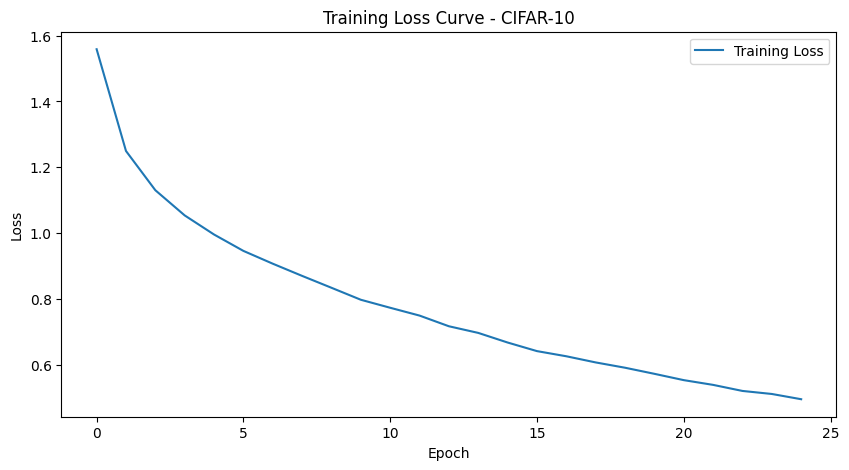

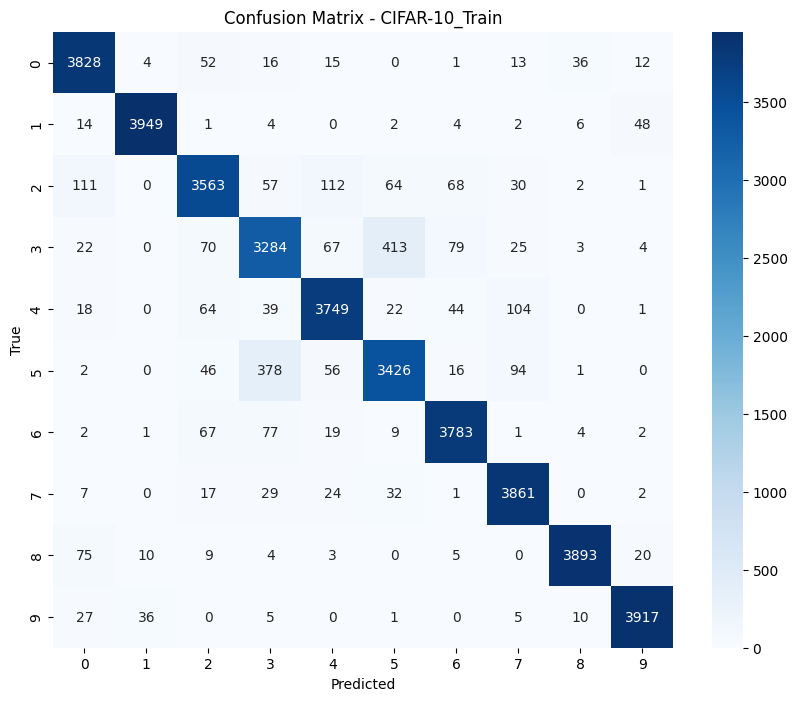

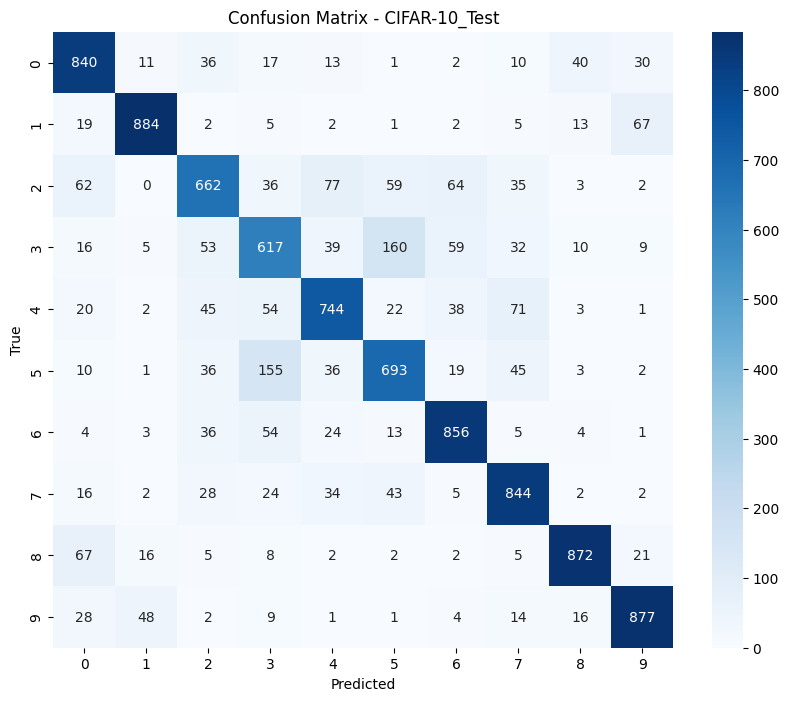


CIFAR-10 Results:
Training Accuracy: 0.9313, F1-Score: 0.9311
Test Accuracy: 0.7889, F1-Score: 0.7882
Training Confusion Matrix:
[[3828    4   52   16   15    0    1   13   36   12]
 [  14 3949    1    4    0    2    4    2    6   48]
 [ 111    0 3563   57  112   64   68   30    2    1]
 [  22    0   70 3284   67  413   79   25    3    4]
 [  18    0   64   39 3749   22   44  104    0    1]
 [   2    0   46  378   56 3426   16   94    1    0]
 [   2    1   67   77   19    9 3783    1    4    2]
 [   7    0   17   29   24   32    1 3861    0    2]
 [  75   10    9    4    3    0    5    0 3893   20]
 [  27   36    0    5    0    1    0    5   10 3917]]
Test Confusion Matrix:
[[840  11  36  17  13   1   2  10  40  30]
 [ 19 884   2   5   2   1   2   5  13  67]
 [ 62   0 662  36  77  59  64  35   3   2]
 [ 16   5  53 617  39 160  59  32  10   9]
 [ 20   2  45  54 744  22  38  71   3   1]
 [ 10   1  36 155  36 693  19  45   3   2]
 [  4   3  36  54  24  13 856   5   4   1]
 [ 16   2  28  

In [28]:
if __name__ == '__main__':
    try:

        print("Training on CIFAR-10 dataset...")
        main(dataset_type='CIFAR-10')
    except KeyboardInterrupt:
        print("Execution interrupted by user.")